# IMPORT PACKAGES

In [1]:
#general
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn

#Gaussian Process/Visualization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

#Neural Network
import edward as ed
import tensorflow as tf
from edward.models import Normal


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# READ IN DATASET

In [2]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h1y = []
data_h1z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1y.append(float(line.strip()[25:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1z.append(float(line.strip()[42:52]))
        count +=1


In [3]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h2y = []
data_h2z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2y.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2z.append(float(line.strip()[42:52]))
        count +=1


In [4]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_oy = []
data_oz = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oy.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oz.append(float(line.strip()[42:52]))
        count +=1


In [5]:
H2O_en = '/Users/yatin/Documents/water/energies.txt'

# read and store the separations
energy = []

with open(H2O_en, 'r') as outf:
    for line in outf:
        energy.append(float(line))

# CALCULATE GEOMETRIES

In [6]:
bond_1 = []
bond_2 = []
side3 = []
for loc in range(0, len(data_oy)):
    bond_1.append(math.sqrt((data_oy[loc]-data_h1y[loc])**2+(data_oz[loc]-data_h1z[loc])**2))
    bond_2.append(math.sqrt((data_oy[loc]-data_h2y[loc])**2+(data_oz[loc]-data_h2z[loc])**2))
    side3.append(math.sqrt((data_h2y[loc]-data_h1y[loc])**2+(data_h2z[loc]-data_h1z[loc])**2))

In [7]:
angle = []

for location in range(0,len(data_oy)):
    angle.append(np.arccos((bond_1[location]**2+bond_2[location]**2-side3[location]**2)/(2*bond_1[location]*bond_2[location])))


In [8]:
dataset = []

for i in range (0, len(data_oy)):
    l = []
    l.append(bond_1[i])
    l.append(bond_2[i])
    l.append(angle[i])
    dataset.append(l)


# DEFINE FUNCTIONS

In [9]:
X = dataset


In [10]:
def split(X):
    cluster = int(input())
    model = KMeans(n_clusters=cluster)
    minsos = []
    l = []
    closepts = []
    m = []
    n = []
    closest = []
    closeindex = []
    smallest = 9999
    for i in range(50):

        model.fit(X)
        y_pred = model.predict(X)
        l = []
        m = []
        n = []
        for i in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}:
            for j in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}[i]:
                if math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2) < smallest:
                    smallest = math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2)
                    closest = dataset[j]
                    closestlabel = j
            l.append(smallest)
            m.append(closest)
            n.append(closestlabel)
            smallest = 9999
        minsos.append(l)
        closepts.append(m)
        closeindex.append(n)
    
    
    smallestsos = 9999
    sos = 0
    mark = 0
    for i in range(len(minsos)):
        sos = 0
        for j in minsos[i]:
            sos = sos+j**2
        if sos < smallestsos:
            smallestsos = sos
            mark = i
    
    trainingset = closepts[mark]
    totalindex = closeindex[mark]
    

    testset = []
    testen = []
    for k in dataset:
        testset.append(k)
    for k in energy:
        testen.append(k)
    for i in range(len(dataset)):
        for j in range(len(trainingset)):
            if trainingset[j] == dataset[i]:
                testset.remove(trainingset[j])
                testen.remove(energy[i])
    test = np.array(testset)
    testenergy = np.array(testen)
    

    A = trainingset
    B = []
    for i in totalindex:
        B.append(energy[i])
    training = np.array(A)
    trainingenergy = np.array(B)
    
    return training, trainingenergy, test, testenergy, model, cluster

In [11]:
def plot_predict(pred, correct):
    plt.figure(figsize = (10, 8))
    plt.plot(pred)
    plt.plot(correct, '--')

In [12]:
from sklearn.metrics import mean_absolute_error

def error_det(pred, correct):
    err = mean_absolute_error(correct, pred)
    return err

# TRAIN GAUSSIAN PROCESS AND RETURN ERROR

In [13]:
training, trainingenergy, test, testenergy, model, cluster = split(dataset)
gp = GaussianProcessRegressor(n_restarts_optimizer=20)
gp.fit(training, trainingenergy)
target_pred_t, std_t = gp.predict(training, return_std = True)
error_det(trainingenergy, target_pred_t)

20


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.003540097134464304

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.2934436572123763

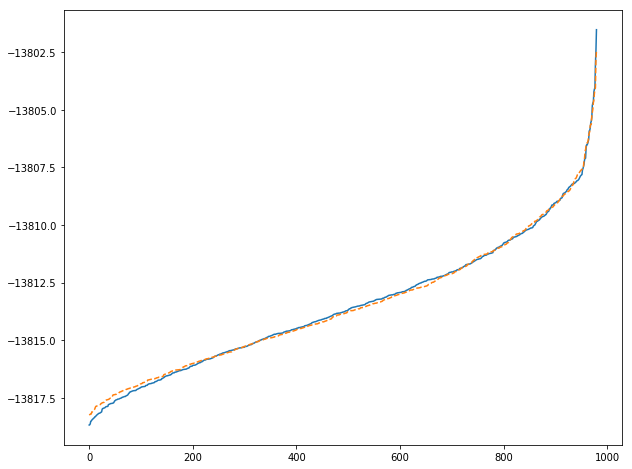

In [14]:
target_pred, std = gp.predict(test, return_std = True)
target_pred_sort = sorted(target_pred)
testenergy_sort = sorted(testenergy)
plot_predict(target_pred_sort, testenergy_sort)
error_det(testenergy, target_pred)

# K-MEANS VISUALIZATION

In [15]:
cluster_dict = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
index_by_cluster = []
data_by_cluster = []
for group in range(cluster):
    index_by_cluster.append(cluster_dict[group])
    

for j in index_by_cluster:
    cluster_list = []
    for k in j:
        for i in range(len(dataset)):
            if k == i:
                cluster_list.append(dataset[k])
    data_by_cluster.append(cluster_list)
    
data_by_cluster_array = []
for i in data_by_cluster:
    data_by_cluster_array.append(np.array(i).T)

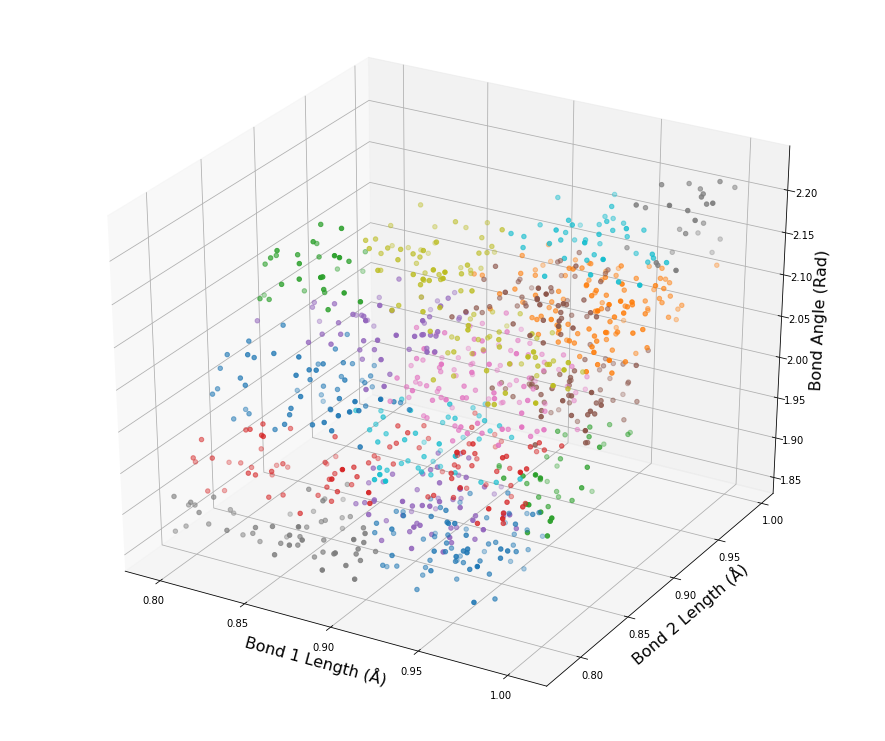

In [16]:
fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)

for i in data_by_cluster_array:
    ax.scatter(i[0, :], i[1, :], i[2, :])
    
ax.view_init()
ax.set_zlabel('Bond Angle (Rad)', fontsize = 16)
plt.xlabel('Bond 1 Length (Å)', fontsize = 16)
plt.ylabel('Bond 2 Length (Å)', fontsize = 16)
plt.savefig("plot_of_"+str(cluster)+"_clusters", dpi = 600)
plt.show()

# VISUALIZE GAUSSIAN PROCESS

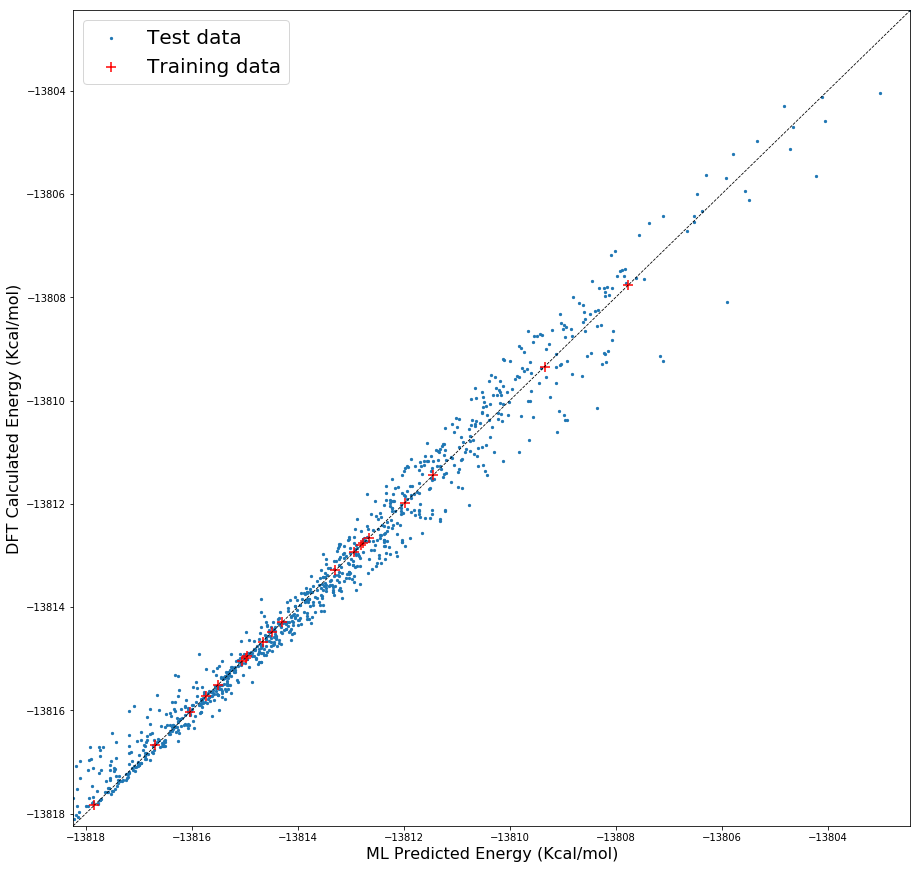

In [17]:
plt.figure(figsize = (15, 15))
plt.scatter(target_pred, testenergy, s = 5, marker = 'o', label='Test data')
plt.scatter(target_pred_t, trainingenergy, s = 100, marker = '+', c = 'r', label = 'Training data')
plt.plot(np.linspace(testenergy.min(), testenergy.max()), np.linspace(testenergy.min(), testenergy.max()), 'k--', linewidth = .8)
plt.legend(fontsize = 20)
plt.ylabel('DFT Calculated Energy (Kcal/mol)', fontsize = 16)
plt.xlabel('ML Predicted Energy (Kcal/mol)', fontsize = 16)
plt.xlim((testenergy.min(), testenergy.max()))
plt.ylim((testenergy.min(), testenergy.max()))
plt.savefig("parity_plot_"+ str(cluster), dpi = 600)
plt.show()

# NEURAL NETWORK

In [18]:
x_train = training.astype(np.float32)
y_train = trainingenergy.astype(np.float32)

In [19]:
print(x_train.shape)
print(y_train.shape)

(20, 3)
(20,)


In [20]:
W_0 = Normal(loc=tf.zeros([3, 2]), scale=tf.ones([3, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [21]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [22]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000)

TypeError: Key-value pair in latent_vars does not have same shape: (3, 2), (1, 2)

# References
1. Jon Vandermause, Steven Torrisi, Simon Batzner (https://github.com/simonbatzner/ML-electron-density)
2. Brockherde, F., Vogt, L., Li, L., Tuckerman, M. E., Burke, K., & Müller, K. R. (2017). Bypassing the Kohn-Sham equations with machine learning. Nature communications, 8(1), 872.
3. Data from: http://quantum-machine.org/datasets/